In [1]:
def read_file(filepath):
    tags=[]
    sentence_tags = []
    sentences = []
    sentence = []
    for line in open(filepath, encoding='utf-8'):
        if line !='\n':
            word, tag = line.strip().split()
            if word.startswith('http://') or word.startswith('https://'):
                word = '<URL>'
            if word.startswith('@'):
                word = '<USR>'
            sentence.append(word)
            sentence_tags.append(tag)
        if line == '\n':
            sentences.append(sentence)
            tags.append(sentence_tags)
            sentence = []
            sentence_tags = []
    return sentences, tags

In [2]:
train_sents, train_tags = read_file('data/train.txt')
val_sents, val_tags = read_file('data/validation.txt')
test_sents, test_tags = read_file('data/train.txt')

In [3]:
for word, tag in zip(train_sents[1], train_tags[1]):
    print(f"{word} ----> {tag}")

Apple ----> B-product
MacBook ----> I-product
Pro ----> I-product
A1278 ----> I-product
13.3 ----> I-product
" ----> I-product
Laptop ----> I-product
- ----> I-product
MD101LL/A ----> I-product
( ----> O
June ----> O
, ----> O
2012 ----> O
) ----> O
- ----> O
Full ----> O
read ----> O
by ----> O
eBay ----> B-company
<URL> ----> O
<URL> ----> O


In [5]:
from keras.preprocessing.text import Tokenizer

sent_tokenizer = Tokenizer(lower=False, oov_token='<UNK>')
sent_tokenizer.fit_on_texts(train_sents)

In [6]:
from collections import defaultdict

len_dict = defaultdict(int)
for sent in train_sents:
    len_dict[len(sent)]+=1

In [7]:
import matplotlib.pyplot as plt

lens_, counts_ = [], []
for len_, count_ in len_dict.items():
        lens_.append(len_)
        counts_.append(count_)

<BarContainer object of 40 artists>

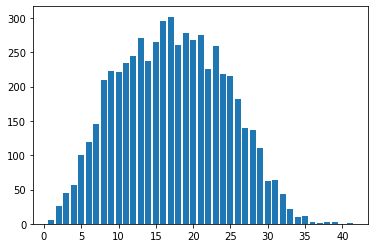

In [8]:
plt.bar(lens_, counts_)

In [15]:
# assuming max len as 40
from keras.preprocessing.sequence import pad_sequences
max_len=40
train_sequences = sent_tokenizer.texts_to_sequences(train_sents)
train_sequences_padded = pad_sequences(train_sequences, padding='post', maxlen=max_len)


In [16]:
val_sequences = sent_tokenizer.texts_to_sequences(val_sents)
val_sequences_padded = pad_sequences(val_sequences, padding='post', maxlen=max_len)

In [20]:
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(train_tags)
train_tag_sequences = tag_tokenizer.texts_to_sequences(train_tags)
train_tag_sequences_padded = pad_sequences(train_tag_sequences, padding='post', maxlen=max_len)

val_tag_sequences = tag_tokenizer.texts_to_sequences(val_tags)
val_tag_sequences_padded = pad_sequences(val_tag_sequences, padding='post', maxlen=max_len)

In [21]:
train_sequences_padded

array([[   9,    2,    5, ...,    0,    0,    0],
       [ 622, 6026, 1742, ...,    0,    0,    0],
       [ 126,  662,    2, ...,    0,    0,    0],
       ...,
       [5952, 5953, 5954, ...,    0,    0,    0],
       [ 210, 2659,   93, ...,    0,    0,    0],
       [   2,    7, 1406, ...,    0,    0,    0]])

In [22]:
train_tag_sequences_padded

array([[ 1,  1,  1, ...,  0,  0,  0],
       [10,  7,  7, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       ...,
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0]])

In [23]:
vocab_size = len(sent_tokenizer.word_index) + 1 #including the padding(0 value) as well
classes = len(tag_tokenizer.word_index) + 1 # considering the padding class as well

In [24]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding, Dropout
from keras.layers import TimeDistributed, Bidirectional

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, 256, mask_zero=True, input_length=max_len ))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 256)           4857600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 200)           285600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 200)           240800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 40, 22)            4422      
Total params: 5,388,422
Trainable params: 5,388,422
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=20,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/20
5795/5795 [==============================] - 46s 8ms/step - loss: 0.6381 - acc: 0.9186 - val_loss: 0.4057 - val_acc: 0.9265
Epoch 2/20
5795/5795 [==============================] - 39s 7ms/step - loss: 0.3453 - acc: 0.9248 - val_loss: 0.3221 - val_acc: 0.9277
Epoch 3/20
5795/5795 [==============================] - 38s 7ms/step - loss: 0.2443 - acc: 0.9329 - val_loss: 0.3201 - val_acc: 0.9263
Epoch 4/20
5795/5795 [==============================] - 38s 7ms/step - loss: 0.2026 - acc: 0.9414 - val_loss: 0.3235 - val_acc: 0.9282
Epoch 5/20
5795/5795 [==============================] - 38s 7ms/step - loss: 0.1773 - acc: 0.9480 - val_loss: 0.3283 - val_acc: 0.9221
Epoch 6/20
5795/5795 [==============================] - 39s 7ms/step - loss: 0.1506 - acc: 0.9569 - val_loss: 0.3331 - val_acc: 0.9224
Epoch 7/20
5795/5795 [==============================] - 40s 7ms/step - loss: 0.1215 - acc: 0.9657 - val_loss: 0.3425 - val_acc: 0.9226
Epoch 8/

In [40]:
model.predict_classes(val_sequences_padded[1].reshape(1,-1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int64)

In [38]:
val_tag_sequences_padded[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Clearly Over fitted

In [41]:
model = Sequential()
model.add(Embedding(vocab_size, 256, mask_zero=True, input_length=max_len ))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [42]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=5,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/5
5795/5795 [==============================] - 46s 8ms/step - loss: 0.6444 - acc: 0.9185 - val_loss: 0.4106 - val_acc: 0.9265
Epoch 2/5
5795/5795 [==============================] - 38s 7ms/step - loss: 0.3503 - acc: 0.9246 - val_loss: 0.3250 - val_acc: 0.9293
Epoch 3/5
5795/5795 [==============================] - 38s 7ms/step - loss: 0.2556 - acc: 0.9310 - val_loss: 0.3231 - val_acc: 0.9301
Epoch 4/5
5795/5795 [==============================] - 39s 7ms/step - loss: 0.2152 - acc: 0.9390 - val_loss: 0.3079 - val_acc: 0.9304
Epoch 5/5
5795/5795 [==============================] - 39s 7ms/step - loss: 0.1912 - acc: 0.9444 - val_loss: 0.3169 - val_acc: 0.9340


In [48]:
model.predict_classes(val_sequences_padded[170].reshape(1,-1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int64)

In [49]:
model = Sequential()
model.add(Embedding(vocab_size, 256, mask_zero=True, input_length=max_len ))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [50]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=5,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/5
5795/5795 [==============================] - 43s 7ms/step - loss: 0.8077 - acc: 0.9134 - val_loss: 0.4525 - val_acc: 0.9265
Epoch 2/5
5795/5795 [==============================] - 34s 6ms/step - loss: 0.4160 - acc: 0.9236 - val_loss: 0.3562 - val_acc: 0.9265
Epoch 3/5
5795/5795 [==============================] - 34s 6ms/step - loss: 0.3010 - acc: 0.9246 - val_loss: 0.3365 - val_acc: 0.9282
Epoch 4/5
5795/5795 [==============================] - 34s 6ms/step - loss: 0.2633 - acc: 0.9280 - val_loss: 0.3420 - val_acc: 0.9283
Epoch 5/5
5795/5795 [==============================] - 34s 6ms/step - loss: 0.2471 - acc: 0.9305 - val_loss: 0.3366 - val_acc: 0.9278


In [52]:
model.predict_classes(val_sequences_padded[1].reshape(1,-1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int64)

In [58]:
model.predict_classes(train_sequences_padded[1].reshape(1,-1))

array([[7, 7, 7, 7, 7, 1, 7, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int64)

In [60]:
train_tag_sequences_padded[1]

array([10,  7,  7,  7,  7,  7,  7,  7,  7,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  6,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [59]:
model = Sequential()
model.add(Embedding(vocab_size, 256, mask_zero=False, input_length=max_len ))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [61]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=5,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/5
5795/5795 [==============================] - 41s 7ms/step - loss: 0.5824 - acc: 0.9113 - val_loss: 0.2002 - val_acc: 0.9692
Epoch 2/5
5795/5795 [==============================] - 32s 5ms/step - loss: 0.1975 - acc: 0.9670 - val_loss: 0.1688 - val_acc: 0.9692
Epoch 3/5
5795/5795 [==============================] - 34s 6ms/step - loss: 0.1539 - acc: 0.9671 - val_loss: 0.1425 - val_acc: 0.9692
Epoch 4/5
5795/5795 [==============================] - 35s 6ms/step - loss: 0.1219 - acc: 0.9673 - val_loss: 0.1394 - val_acc: 0.9697
Epoch 5/5
5795/5795 [==============================] - 33s 6ms/step - loss: 0.1052 - acc: 0.9702 - val_loss: 0.1402 - val_acc: 0.9707


In [62]:
model.predict_classes(train_sequences_padded[1].reshape(1,-1))

array([[7, 7, 7, 7, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [63]:
train_tag_sequences_padded[1]

array([10,  7,  7,  7,  7,  7,  7,  7,  7,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  6,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [64]:
train_sents[1]

['Apple',
 'MacBook',
 'Pro',
 'A1278',
 '13.3',
 '"',
 'Laptop',
 '-',
 'MD101LL/A',
 '(',
 'June',
 ',',
 '2012',
 ')',
 '-',
 'Full',
 'read',
 'by',
 'eBay',
 '<URL>',
 '<URL>']

In [77]:
y_pred_classes = list(model.predict_classes(train_sequences_padded[1].reshape(1,-1)).flatten())
y_true_classes = train_tag_sequences_padded[1]
tokens = train_sents[1]
for y_pred, y_true, token in zip(y_pred_classes, y_true_classes, tokens):
    if y_true != 0 or y_pred!= 0:
        print(f'{token} ---->  {tag_tokenizer.index_word[y_pred]}(pred label) -----> {tag_tokenizer.index_word[y_true]}(true label)')

Apple ---->  I-product(pred label) -----> B-product(true label)
MacBook ---->  I-product(pred label) -----> I-product(true label)
Pro ---->  I-product(pred label) -----> I-product(true label)
A1278 ---->  I-product(pred label) -----> I-product(true label)
13.3 ---->  I-other(pred label) -----> I-product(true label)
" ---->  O(pred label) -----> I-product(true label)
Laptop ---->  I-other(pred label) -----> I-product(true label)
- ---->  O(pred label) -----> I-product(true label)
MD101LL/A ---->  O(pred label) -----> I-product(true label)
( ---->  O(pred label) -----> O(true label)
June ---->  O(pred label) -----> O(true label)
, ---->  O(pred label) -----> O(true label)
2012 ---->  O(pred label) -----> O(true label)
) ---->  O(pred label) -----> O(true label)
- ---->  O(pred label) -----> O(true label)
Full ---->  O(pred label) -----> O(true label)
read ---->  O(pred label) -----> O(true label)
by ---->  O(pred label) -----> O(true label)
eBay ---->  O(pred label) -----> B-company(true

In [74]:
tag_tokenizer.index_word[7]

'I-product'

In [78]:
model = Sequential()
model.add(Embedding(vocab_size, 50, mask_zero=False, input_length=max_len ))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [80]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=6,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/6
5795/5795 [==============================] - 27s 5ms/step - loss: 0.6969 - acc: 0.8691 - val_loss: 0.2103 - val_acc: 0.9691
Epoch 2/6
5795/5795 [==============================] - 21s 4ms/step - loss: 0.2187 - acc: 0.9650 - val_loss: 0.1950 - val_acc: 0.9692
Epoch 3/6
5795/5795 [==============================] - 22s 4ms/step - loss: 0.2035 - acc: 0.9668 - val_loss: 0.1825 - val_acc: 0.9692
Epoch 4/6
5795/5795 [==============================] - 22s 4ms/step - loss: 0.1765 - acc: 0.9670 - val_loss: 0.1579 - val_acc: 0.9692
Epoch 5/6
5795/5795 [==============================] - 22s 4ms/step - loss: 0.1396 - acc: 0.9671 - val_loss: 0.1434 - val_acc: 0.9694
Epoch 6/6
5795/5795 [==============================] - 22s 4ms/step - loss: 0.1166 - acc: 0.9686 - val_loss: 0.1441 - val_acc: 0.9700


In [82]:

for i in range(3,7):
    y_pred_classes = list(model.predict_classes(train_sequences_padded[i].reshape(1,-1)).flatten())
    y_true_classes = train_tag_sequences_padded[i]
    tokens = train_sents[i]
    for y_pred, y_true, token in zip(y_pred_classes, y_true_classes, tokens):
        if y_true != 0 or y_pred!= 0:
            print(f'{token} ---->  {tag_tokenizer.index_word[y_pred]}(pred label) -----> {tag_tokenizer.index_word[y_true]}(true label)')
    print('======================================================================')

<USR> ---->  O(pred label) -----> O(true label)
the ---->  O(pred label) -----> O(true label)
quest ---->  O(pred label) -----> O(true label)
line ---->  O(pred label) -----> O(true label)
im ---->  O(pred label) -----> O(true label)
assuming ---->  O(pred label) -----> O(true label)
it ---->  O(pred label) -----> O(true label)
will ---->  O(pred label) -----> O(true label)
be ---->  O(pred label) -----> O(true label)
the ---->  O(pred label) -----> O(true label)
same ---->  O(pred label) -----> O(true label)
way ---->  O(pred label) -----> O(true label)
with ---->  O(pred label) -----> O(true label)
awe ---->  O(pred label) -----> O(true label)
thur ---->  O(pred label) -----> O(true label)
<USR> ---->  O(pred label) -----> O(true label)
<USR> ---->  O(pred label) -----> O(true label)
<USR> ---->  O(pred label) -----> O(true label)
<USR> ---->  O(pred label) -----> O(true label)
<USR> ---->  O(pred label) -----> O(true label)
still ---->  O(pred label) -----> O(true label)
perception 

In [138]:
from evaluation import precision_recall_f1

In [84]:
model = Sequential()
model.add(Embedding(vocab_size, 200, mask_zero=False, input_length=max_len ))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(200, return_sequences=True, recurrent_dropout=0.1)))
# model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [85]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=4,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/4
5795/5795 [==============================] - 36s 6ms/step - loss: 0.3594 - acc: 0.9286 - val_loss: 0.1807 - val_acc: 0.9692
Epoch 2/4
5795/5795 [==============================] - 29s 5ms/step - loss: 0.1577 - acc: 0.9676 - val_loss: 0.1372 - val_acc: 0.9706
Epoch 3/4
5795/5795 [==============================] - 29s 5ms/step - loss: 0.1093 - acc: 0.9711 - val_loss: 0.1297 - val_acc: 0.9729
Epoch 4/4
5795/5795 [==============================] - 29s 5ms/step - loss: 0.0829 - acc: 0.9770 - val_loss: 0.1348 - val_acc: 0.9735


In [87]:
for i in range(100, 110):
    y_pred_classes = list(model.predict_classes(train_sequences_padded[i].reshape(1,-1)).flatten())
    y_true_classes = train_tag_sequences_padded[i]
    tokens = train_sents[i]
    for y_pred, y_true, token in zip(y_pred_classes, y_true_classes, tokens):
        if y_true != 0 or y_pred!= 0:
            print(f'{token} ---->  {tag_tokenizer.index_word[y_pred]}(pred label) -----> {tag_tokenizer.index_word[y_true]}(true label)')
    print('======================================================================')

Wow ---->  O(pred label) -----> O(true label)
!.. ---->  O(pred label) -----> O(true label)
Michael ---->  B-person(pred label) -----> B-person(true label)
Owen ---->  I-person(pred label) -----> I-person(true label)
jwus ---->  O(pred label) -----> O(true label)
just ---->  O(pred label) -----> O(true label)
ask ---->  O(pred label) -----> O(true label)
who ---->  O(pred label) -----> O(true label)
he ---->  O(pred label) -----> O(true label)
think ---->  O(pred label) -----> O(true label)
will ---->  O(pred label) -----> O(true label)
finish ---->  O(pred label) -----> O(true label)
in ---->  O(pred label) -----> O(true label)
top ---->  O(pred label) -----> O(true label)
four ---->  O(pred label) -----> O(true label)
as ---->  O(pred label) -----> O(true label)
3rd ---->  O(pred label) -----> O(true label)
and ---->  O(pred label) -----> O(true label)
4th ---->  O(pred label) -----> O(true label)
.. ---->  O(pred label) -----> O(true label)
he ---->  O(pred label) -----> O(true labe

KeyError: 0

In [92]:
print(train_sequences_padded)
print(train_sequences_padded.shape)

[[   9    2    5 ...    0    0    0]
 [ 622 6026 1742 ...    0    0    0]
 [ 126  662    2 ...    0    0    0]
 ...
 [5952 5953 5954 ...    0    0    0]
 [ 210 2659   93 ...    0    0    0]
 [   2    7 1406 ...    0    0    0]]
(5795, 40)


In [91]:
print(train_tag_sequences_padded)
print(train_tag_sequences_padded.shape)

[[ 1  1  1 ...  0  0  0]
 [10  7  7 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 ...
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]]
(5795, 40)


In [93]:
model = Sequential()
model.add(Embedding(vocab_size, 200, mask_zero=True, input_length=max_len ))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(200, return_sequences=True, recurrent_dropout=0.1)))
# model.add(Bidirectional(LSTM(16, return_sequences=True, recurrent_dropout=0.2)))
model.add(TimeDistributed(Dense(classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [94]:
history = model.fit(train_sequences_padded, train_tag_sequences_padded.reshape(-1, max_len, 1),
          epochs=4,
          validation_data=(val_sequences_padded, val_tag_sequences_padded.reshape(-1, 40, 1)), verbose=1)

Train on 5795 samples, validate on 724 samples
Epoch 1/4
5795/5795 [==============================] - 39s 7ms/step - loss: 0.6567 - acc: 0.9168 - val_loss: 0.3863 - val_acc: 0.9265
Epoch 2/4
5795/5795 [==============================] - 32s 6ms/step - loss: 0.3349 - acc: 0.9251 - val_loss: 0.3313 - val_acc: 0.9294
Epoch 3/4
5795/5795 [==============================] - 32s 6ms/step - loss: 0.2464 - acc: 0.9334 - val_loss: 0.3242 - val_acc: 0.9311
Epoch 4/4
5795/5795 [==============================] - 33s 6ms/step - loss: 0.2122 - acc: 0.9407 - val_loss: 0.3239 - val_acc: 0.9331


**Observations**
<ul>
<li>Need to check the role of mask_zero. As per the initial exploration, padding should be given 0 and when the zero is masked then the rnn don't consider those values.
 <li>As the number of RNN units increases the values that can be memorized increases. Gives significance boost upto some extent. Need to keep the performace of the network as well.
 <li>
</ul>

In [95]:
for i in range(100, 110):
    y_pred_classes = list(model.predict_classes(train_sequences_padded[i].reshape(1,-1)).flatten())
    y_true_classes = train_tag_sequences_padded[i]
    tokens = train_sents[i]
    for y_pred, y_true, token in zip(y_pred_classes, y_true_classes, tokens):
        if y_true != 0 or y_pred!= 0:
            print(f'{token} ---->  {tag_tokenizer.index_word[y_pred]}(pred label) -----> {tag_tokenizer.index_word[y_true]}(true label)')
    print('======================================================================')

Wow ---->  O(pred label) -----> O(true label)
!.. ---->  O(pred label) -----> O(true label)
Michael ---->  B-person(pred label) -----> B-person(true label)
Owen ---->  I-person(pred label) -----> I-person(true label)
jwus ---->  O(pred label) -----> O(true label)
just ---->  O(pred label) -----> O(true label)
ask ---->  O(pred label) -----> O(true label)
who ---->  O(pred label) -----> O(true label)
he ---->  O(pred label) -----> O(true label)
think ---->  O(pred label) -----> O(true label)
will ---->  O(pred label) -----> O(true label)
finish ---->  O(pred label) -----> O(true label)
in ---->  O(pred label) -----> O(true label)
top ---->  O(pred label) -----> O(true label)
four ---->  O(pred label) -----> O(true label)
as ---->  O(pred label) -----> O(true label)
3rd ---->  O(pred label) -----> O(true label)
and ---->  O(pred label) -----> O(true label)
4th ---->  O(pred label) -----> O(true label)
.. ---->  O(pred label) -----> O(true label)
he ---->  O(pred label) -----> O(true labe

In [108]:
test_sequences = sent_tokenizer.texts_to_sequences(test_sents)
test_sequences_padded = pad_sequences(test_sequences, padding='post', maxlen=max_len)

test_preds = model.predict_classes(test_sequences_padded)

In [109]:
test_preds = test_preds.tolist()
pred_tags = []

for i, sent in enumerate(test_sents):
    sliced_preds = test_preds[i][:len(sent)]
    pred_tags_ = [tag_tokenizer.index_word[idx] for idx in sliced_preds]
    pred_tags.append(pred_tags_)

In [133]:
pred_tags_flat = [item for sublist in pred_tags for item in sublist]
test_preds_flat = [item for sublist in test_tags for item in sublist]

In [141]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [142]:
print(classification_report(test_preds_flat, pred_tags_flat))

             precision    recall  f1-score   support

musicartist       0.00      0.00      0.00       232
    product       0.03      0.02      0.02       318
     person       0.14      0.44      0.22       886
    company       0.31      0.29      0.30       643
      movie       0.00      0.00      0.00        68
 sportsteam       0.00      0.00      0.00       217
   facility       0.10      0.11      0.10       314
        loc       0.38      0.43      0.40       996
      other       0.14      0.07      0.09       757
     tvshow       0.00      0.00      0.00        58

  micro avg       0.21      0.24      0.22      4489
  macro avg       0.19      0.24      0.20      4489

